In [1]:
import numpy as np
import os
import kagglehub
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F

In [2]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, ds_file, labels, transform=None):
        self.transform = transform
        data_np = np.load(ds_file)
        labels_np = np.load(labels)
        self.data = torch.from_numpy(data_np)
        self.labels = torch.from_numpy(labels_np)
        self.length = data_np.shape[0]
    def __len__(self):
        return self.length
    def __getitem__(self, index):
        if self.transform:
            self.data = self.transform(self.data)

        return self.data[index], self.labels[index]

Using Colab cache for faster access to the 'crowd-counting' dataset.
Path to dataset files: /kaggle/input/crowd-counting


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


tensor([35], dtype=torch.uint8)


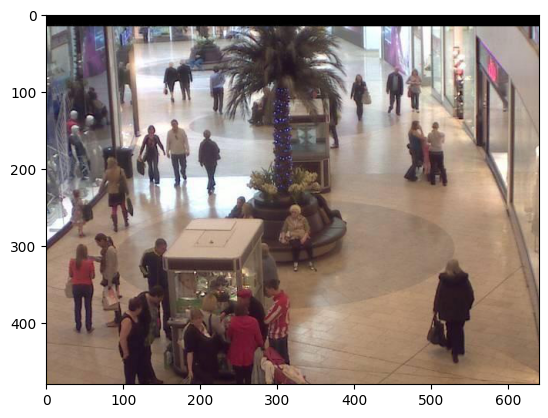

In [3]:
# Download latest version

path = kagglehub.dataset_download("fmena14/crowd-counting")

# train_data = np.load(os.path.join(path, "images.npy"))
all_data = DataSet(os.path.join(path, "images.npy"), os.path.join(path, "labels.npy"))
training_size = int(0.7 * len(all_data))
testing_size = (len(all_data)-training_size)

train_data, test_data = torch.utils.data.random_split(all_data, [training_size, testing_size])
# plt.imshow(train_data[0])
# train_data_tensor = torch.from_numpy(train_data).float()
# print(train_data_tensor.shape)
labels = np.load(os.path.join(path, "labels.npy"))


train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=8)

print("Path to dataset files:", path)

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(npimg)



# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# print(images)


# show images
imshow(images[0])
print(labels[0])

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*157*117, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [9]:
def train(network, device):
    for epoch in range(50):  # loop over the dataset multiple times
        correct = 0
        total = 0
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            # print(inputs.permute(0, 3, 2, 1).shape)
            # print(labels[0])

            # print(inputs.shape[0]

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = network(inputs.permute(0, 3, 2, 1).float())
            loss = criterion(outputs.float(), labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
        print(running_loss)

In [10]:
net = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
net = net.to(device)
train(net, device)

cuda


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


3759901.903163433
2527.408945441246
2116.7489157021046
958.5806901082397
541.4235696457326
426.80756996944547
569.9829054521397
983.0608637705445
3116.8194968625903
6861.65383464098
1190.3370666205883
561.581798799336
317.5290185213089
200.59426888637245
208.5397316981107
291.30603689327836
525.0753079727292
515.3466352634132
499.9572090283036
516.4305376522243
525.889679543674
549.2618020065129
431.40248540602624
289.7515213340521
275.205979174003
435.5312607623637
661.8938883338124
539.9466929733753
344.6091929152608
1747.8063498465344
2597.492175936699
661.6983444690704
270.90279539860785
183.21201963350177
248.69551029335707
320.3138662260026
339.8812359543517
274.47108605131507
267.588847048115
16996.710649702698
17847.989067077637
17046.780222415924
16384.87009319663
7017.765699416399
2170.223031759262
957.0810565836728
467.38402020186186
266.9026194438338
166.8642693683505
122.37193666212261


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Predicted:  tensor(0, device='cuda:0') tensor(0, device='cuda:0') tensor(0, device='cuda:0') tensor(0, device='cuda:0')
Truth:  tensor([41], dtype=torch.uint8) tensor([33], dtype=torch.uint8) tensor([41], dtype=torch.uint8) tensor([21], dtype=torch.uint8)
Average error on the test images (in number of people missed): 2.413043 


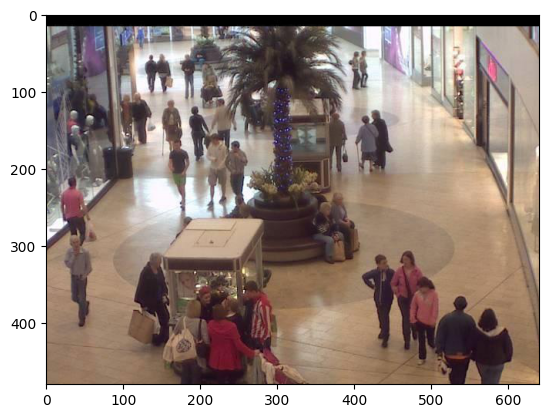

In [32]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

outputs = net(images.to(device).permute(0, 3, 2, 1).float())

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % predicted[j]
                              for j in range(4)))
# print images
imshow(images[0])


print('Truth: ', ' '.join('%5s' % labels[j]
                              for j in range(4)))

total = 0.0
total_error = 0.0 
with torch.no_grad():
    for data in test_loader:
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images.permute(0, 3, 2, 1).float())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        

        error = torch.mean(torch.abs(outputs - labels))
        batch_size = labels.size(0)
        total_error += error * batch_size

#print('Accuracy of the network on the 10000 test images: %d %%' % (
    #100 * correct / total))

print('Average error on the test images (in number of people missed): %f ' %(
    total_error / total))
